We start by loading the necessary libraries

In [1]:
import pandas as pd
from scipy.spatial.distance import pdist, jaccard
from scipy.stats import pearsonr,spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.interpolate import interp1d
from scipy.spatial.distance import correlation,cosine
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import numpy as np
from seaborn import heatmap
%matplotlib inline

We load the txt files into dataframes.

In [2]:
df1 = pd.read_csv('../2022-01-18/run-1-1.csv',delimiter=";",decimal=",")
df2 = pd.read_csv('../2022-01-18/run-1-2.csv',delimiter=";",decimal=",")
df3 = pd.read_csv('../2022-01-18/run-2-1.csv',delimiter=";",decimal=",")
df4 = pd.read_csv('../2022-01-18/run-2-2.csv',delimiter=";",decimal=",")

From each dataframe associated with a file, we only keep those values that are between 2 and 40.

In [3]:
df1

MW       1-1       2-1       3-1      4-1       5-1      6-1  \
0     1.0465   32.4470   32.3307   30.9649  40.4303   38.6140  45.9013   
1     1.1176   32.9252   36.3244   34.8174  42.1912   40.1404  44.7273   
2     1.1887   34.3637   40.8904   36.0498  40.5546   38.0220  44.6489   
3     1.2598   35.8826   40.0483   37.2951  38.7345   38.4683  40.7327   
4     1.3309   35.2789   36.5412   39.4988  36.8719   39.4184  39.0522   
..       ...       ...       ...       ...      ...       ...      ...   
231  44.2151  114.1113  137.5666  100.5844  99.8578  167.3509  54.2258   
232  44.4777  116.6860  132.4340   97.4985  96.1519  168.7568  53.4736   
233  44.7402  120.4569  126.9519   98.2958  89.4560  171.9211  51.3781   
234  45.0028  118.9714  123.7157   94.4664  89.7627  179.4211  48.0750   
235  45.2654  117.3258  125.1531   88.3896  89.2198  176.5753  48.8605   

          7-1      8-1      9-1  ...      14-1      15-1      16-1      17-1  \
0     42.3338  41.6341  43.7363  ...   47.5324   40.6169   45.3692   40.0191   
1     40.3815  43.3488  46.4766  ...   47.8394   43.9128   45.0939   35.5114   
2     40.5303  45.3356  46.8251  ...   40.9239   44.4306   43.1883   35.0713   
3     40.6461  47.4029  46.9014  ...   41.0100   45.5429   45.0830   38.5180   
4     43.8142  51.2077  49.8160  ...   44.2603   47.7319   40.7121   38.5938   
..        ...      ...      ...  ...       ...       ...       ...       ...   
231  174.3393  87.4110  72.5192  ...  221.2049  194.4573  152.7073  238.1005   
232  177.2212  85.7454  71.6549  ...  208.6457  197.5206  150.8521  233.5519   
233  169.1130  79.1331  72.5473  ...  208.3069  201.8512  147.2982  227.9852   
234  157.4769  78.9364  71.5369  ...  216.7912  206.6457  139.4746  217.9466   
235  150.9374  80.5299  73.7852  ...  219.4871  207.3297  137.3914  210.7540   

        18-1      19-1      20-1      21-1     22-1     23-1  
0    38.7534   35.0493   35.7341   27.2979  37.2317  41.3975  
1    37.6981   35.9151   41.5253   28.6805  37.5066  43.3890  
2    39.8769   40.2268   41.5397   28.7758  37.6301  45.6390  
3    41.8762   39.7187   41.0368   28.2748  37.8593  48.1717  
4    39.7572   34.5861   44.2261   28.4356  36.2877  51.9055  
..       ...       ...       ...       ...      ...      ...  
231  87.7737  268.0561  122.3154  113.5062  65.4448  56.2062  
232  89.1166  259.2057   81.1372  104.5004  71.5813  55.1318  
233  82.9451  251.2802   81.5272  105.2802  67.0003  51.8868  
234  81.4047  245.9952   77.7132  106.0314  65.0399  49.8174  
235  79.3736  237.9712   72.9569   98.7303  67.6591  45.1472  

[236 rows x 24 columns]

In [4]:
df1 = df1[(df1['MW']>=1.9) & (df1['MW']<=41)]
df2 = df2[(df2['MW']>=1.9) & (df2['MW']<=41)]
df3 = df3[(df3['MW']>=1.9) & (df3['MW']<=41)]
df4 = df4[(df4['MW']>=1.9) & (df4['MW']<=41)]

The next function is used to combine a list of dataframes. Since different kDa values might appear in different files, we perform an interpolation and obtain values with a step of 0.1 in the range from 2 to 40.

In [5]:
def buildDataframe(dfList,dfNames):
    
    samples = []
    names = []
    samples.append(np.arange(2.0,40,0.1))
    names.append('points')
    for df,name in zip(dfList,dfNames):
        columns = df.columns[1:]
        for c in columns:
            f = interp1d(df['MW'],df[c])
            samples.append(f(np.arange(2.0,40,0.1)))
            names.append(c)
    
    return pd.DataFrame(data=np.transpose(samples),columns=names,index=None)

Combine the loaded dataframes.

In [6]:
newdf = buildDataframe([df1,df2,df3,df4],['','','',''])

We now define a set of auxiliary functions.

In [17]:
def generate_spectra(df):
    """
    Generate spectra matrix from dataframe
    
    Parameters
    ----------
    df : dataframe
         A dataframe where the first row contains the names of the samples and for each sample we have its spectra
    
    Returns
    ----------
    matrix : narray
             The spectra associated with each sample
    names  : list
             The list of names of the samples
    """
    
    names = df.columns[1:]
        
    
    return np.transpose(df.values[:,1:]), names   

In [18]:
def compute_distance(vector1,vector2,metric='correlation'):
    """
    Compute the distance of two spectra vectors using either the correlation or cosine distance.
    
    Parameters
    ----------
    vector1 : array
    vector2 : array
       Must have the same size than vector1
    metric  : string
       Either correlation or cosine
    
    Returns
    ----------
    The distance between vector1 and vector2 using the given metric. 
    """
    if(metric=='correlation'):
        return correlation(vector1,vector2)
    if(metric=='cosine'):
        return cosine(vector1,vector2)

In [19]:
def generate_similarity_matrix(df,metric='correlation'):
    """
    Generates the similarity matrix of a dataframe
    
    Parameters
    ----------
    df : dataframe
    metric  : string
       Either correlation or cosine
    
    Returns
    ----------
    The similarity matrix associated with a dataframe
    """
    spectra,names = generate_spectra(df)
    
    matrix  = np.zeros((len(names),len(names)),dtype='float32')
    for i in range(0,len(names)):
        for j in range(i+1,len(names)):
            matrix[i][j] = compute_distance(spectra[i],
                                            spectra[j],
                                            metric)
            matrix[j][i] = matrix[i][j]
    return matrix, names

In [20]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [21]:
def generate_dendogram(df,linkage='average',metric='correlation',threshold=0.2,name='dendogram.svg'):
    """
    Generates dendogram
    
    Parameters
    ----------
    df : dataframe
        A dataframe where the first column contains the names of the samples and the second
        contains the molecular weights
    linkage: string
        The linkage method for building the dendogram:
        ‘ward’, ‘complete’, ‘average’, ‘single’.
    metric: string
        One of the following metrics to compute the distance matrix:
        'pearson' or 'spearman'
    threshold: float >=0 and <=1
        Value that is considered to create a cluster. 
    name: string
        Path where the dendogram will be saved
    Returns
    ----------
    This methods shows the associated dendogram and saves the image.
    """

    if(metric=='correlation' or metric=='cosine'):            
        m,names = generate_similarity_matrix(df,metric)
    else:
        raise Excepction('Only jaccard and dice are supported')
    
    clustering = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage=linkage,
                                      distance_threshold=threshold)
    clustering.fit(m)
    
    plt.figure(figsize=(55, 2*len(names)))
    plot_dendrogram(clustering,leaf_font_size=1*len(names),orientation='left',labels = names)
    plt.savefig(name)
    

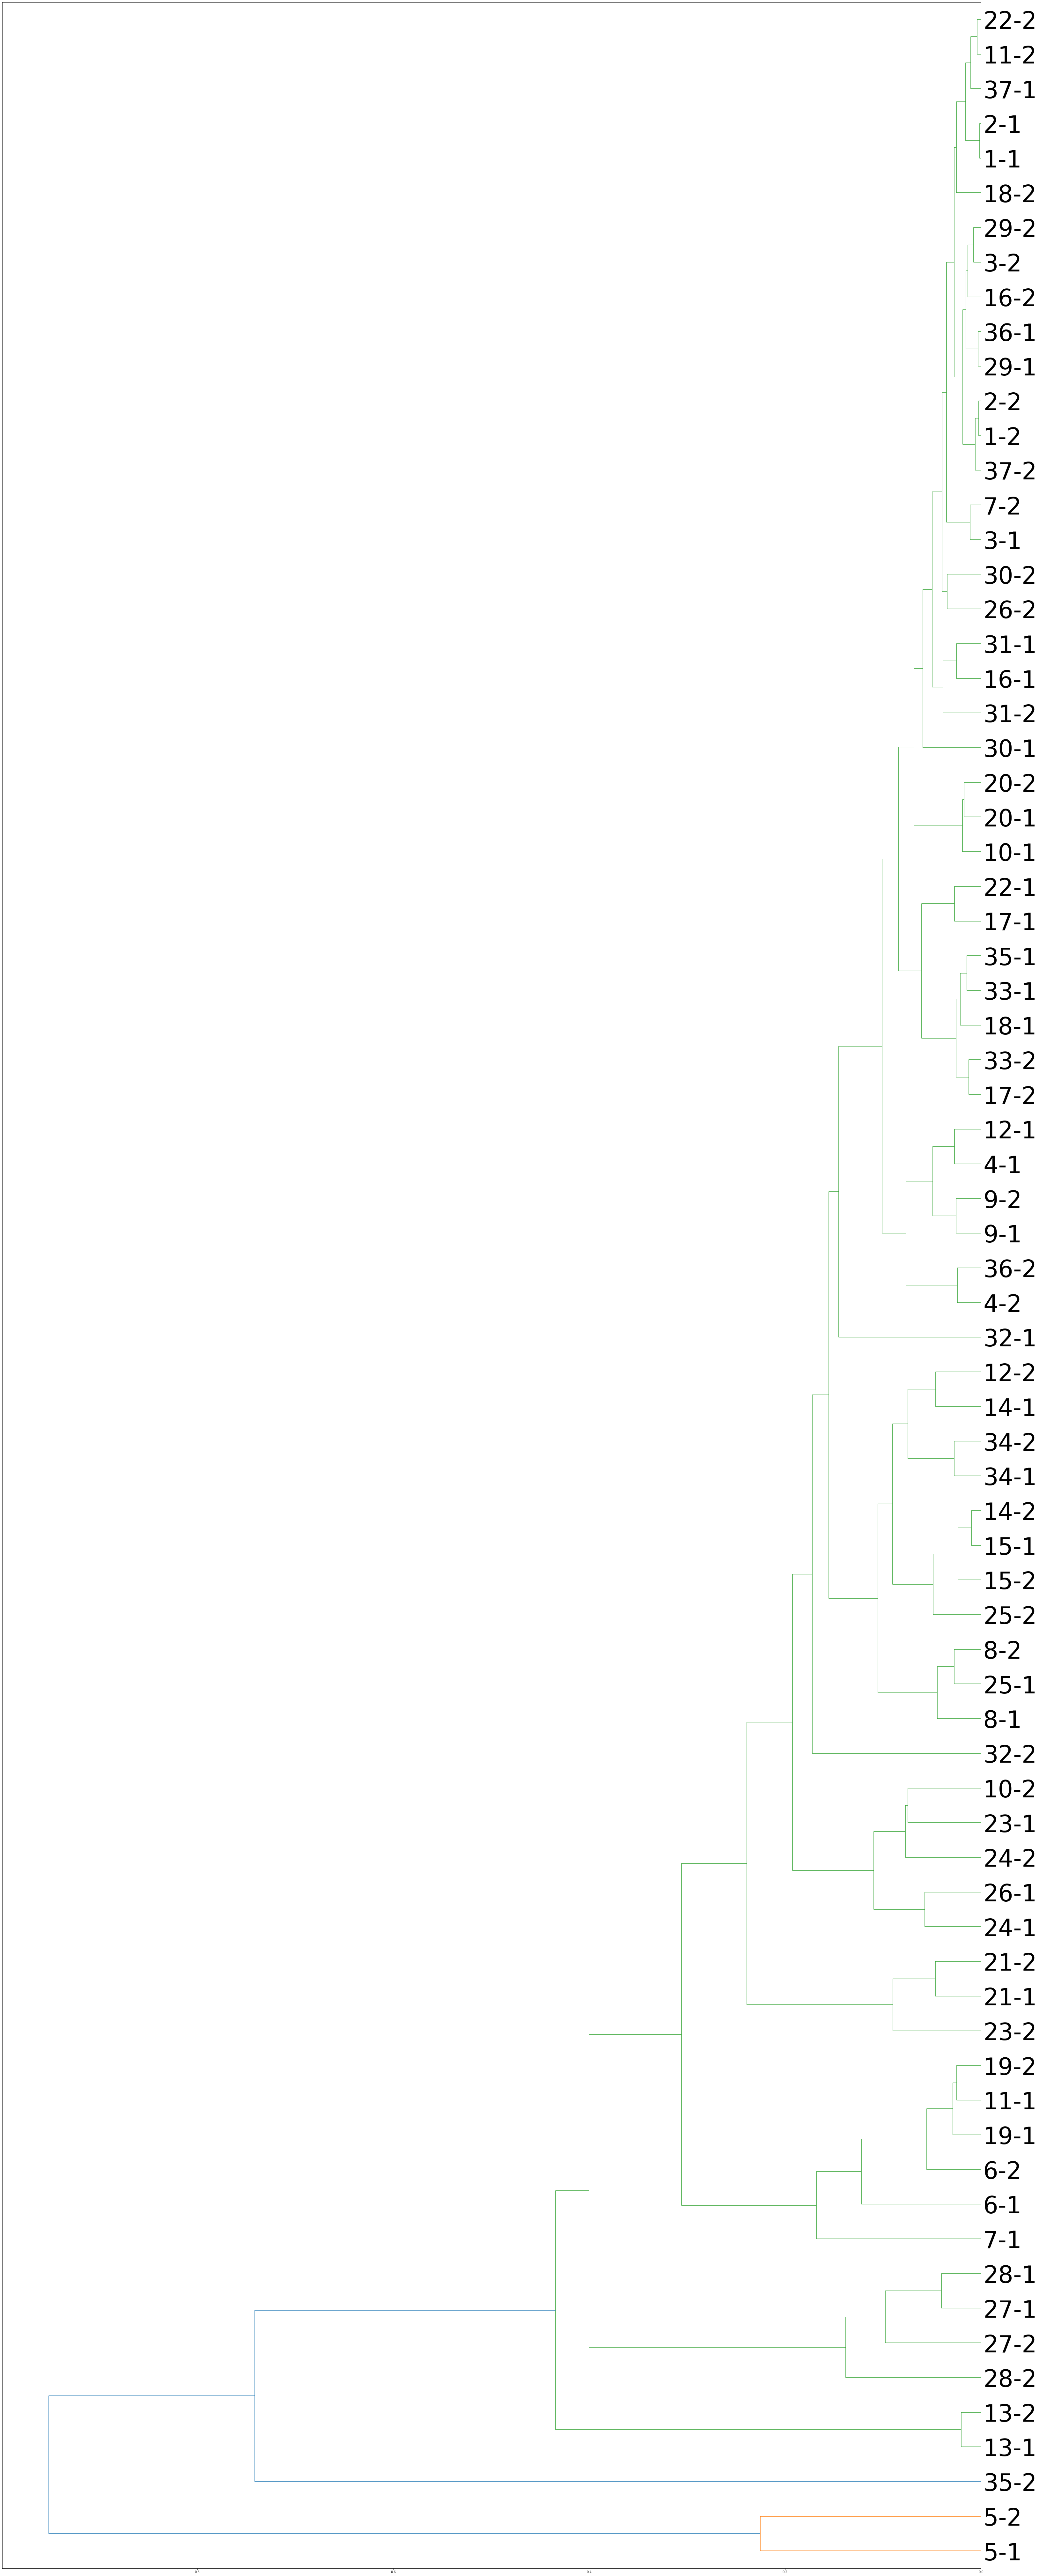

In [22]:
generate_dendogram(newdf,name='dendogram.svg')

The next cells are for showing the spectra.

In [18]:
df1['1']

321     27.0258
322     25.5089
323     24.3266
324     28.9447
325     29.0594
         ...   
522    367.4961
523    347.0887
524    331.5244
525    336.7840
526    321.1518
Name: 1, Length: 206, dtype: float64

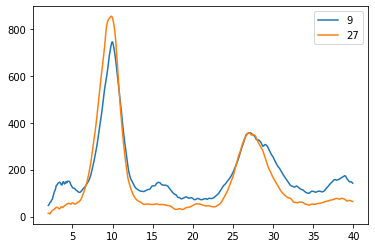

In [26]:
plt.plot(newdf['points'],newdf['9'],#newdf['points'],newdf['12'],
        newdf['points'],newdf['27'],#newdf['points'],newdf['20']
        )
plt.legend(['9','27'])
plt.savefig('cluster_9_27.png')

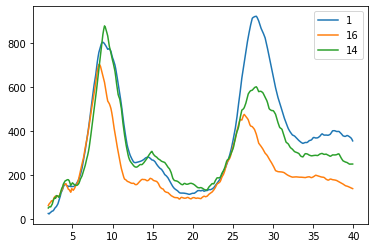

In [21]:
plt.plot(newdf['points'],newdf['1'],newdf['points'],newdf['14'],
         newdf['points'],newdf['16'])
plt.legend(['1','16','14'])
plt.savefig('cluster2.png')

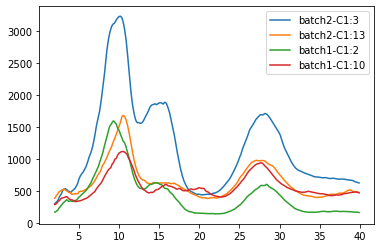

In [16]:
plt.plot(newdf['points'],newdf['batch2-C1:3'],newdf['points'],newdf['batch2-C1:13'],
         newdf['points'],newdf['batch1-C1:2'],newdf['points'],newdf['batch1-C1:10'])
plt.legend(['batch2-C1:3','batch2-C1:13','batch1-C1:2','batch1-C1:10'])
plt.savefig('cluster2.png')

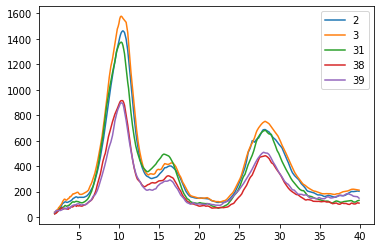

In [22]:
plt.plot(newdf['points'],newdf['2'],newdf['points'],newdf['3'],
         newdf['points'],newdf['31'],newdf['points'],newdf['38'],
        newdf['points'],newdf['39'])
plt.legend(['2','3','31','38','39'])
plt.savefig('cluster3.png')

In [39]:
def generate_heatmap(df,metric='correlation',name='heatmap.svg'):
    m,names = generate_similarity_matrix(df,metric)
    plt.clf()
    plt.figure(figsize=(len(names)+1, len(names)))
    heatmap(1-m,xticklabels=names,yticklabels=names,annot=True)
    plt.savefig(name)

<Figure size 432x288 with 0 Axes>

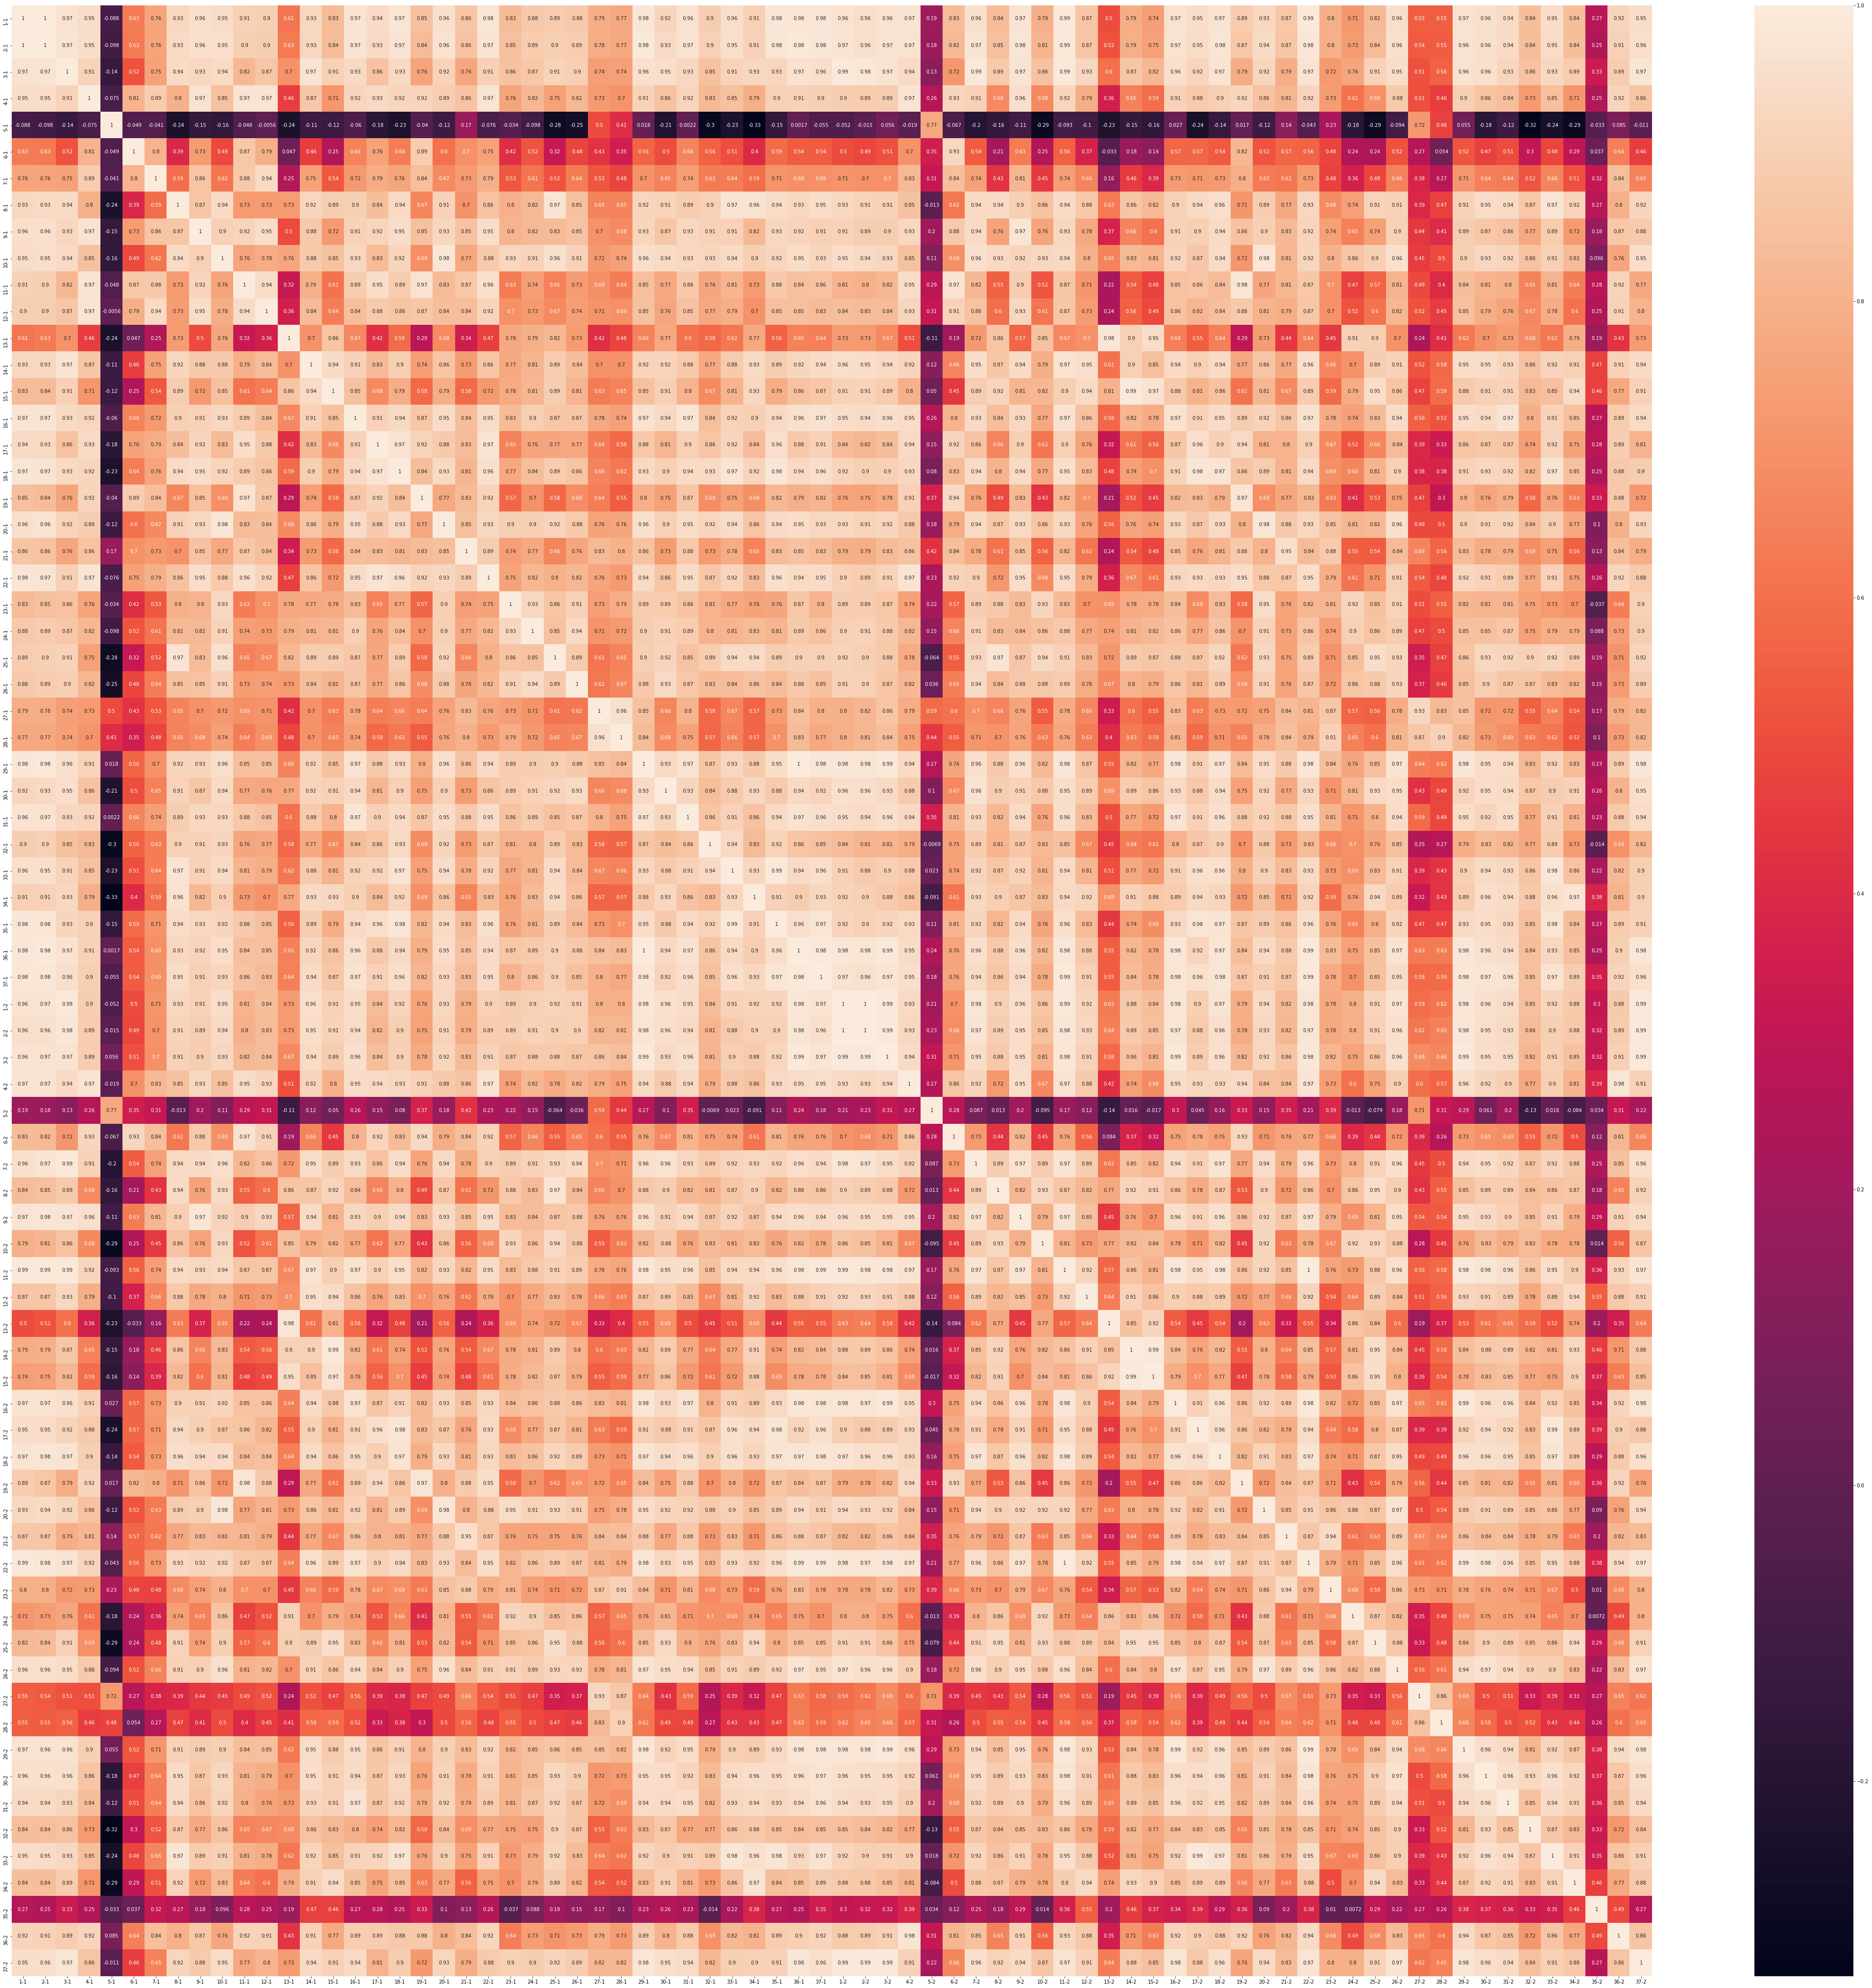

In [40]:
generate_heatmap(newdf)

In [43]:
cols = ['points']
for i in range(0,37):
    cols.append(str(i+1)+'-1')
    cols.append(str(i+1)+'-2')

<Figure size 432x288 with 0 Axes>

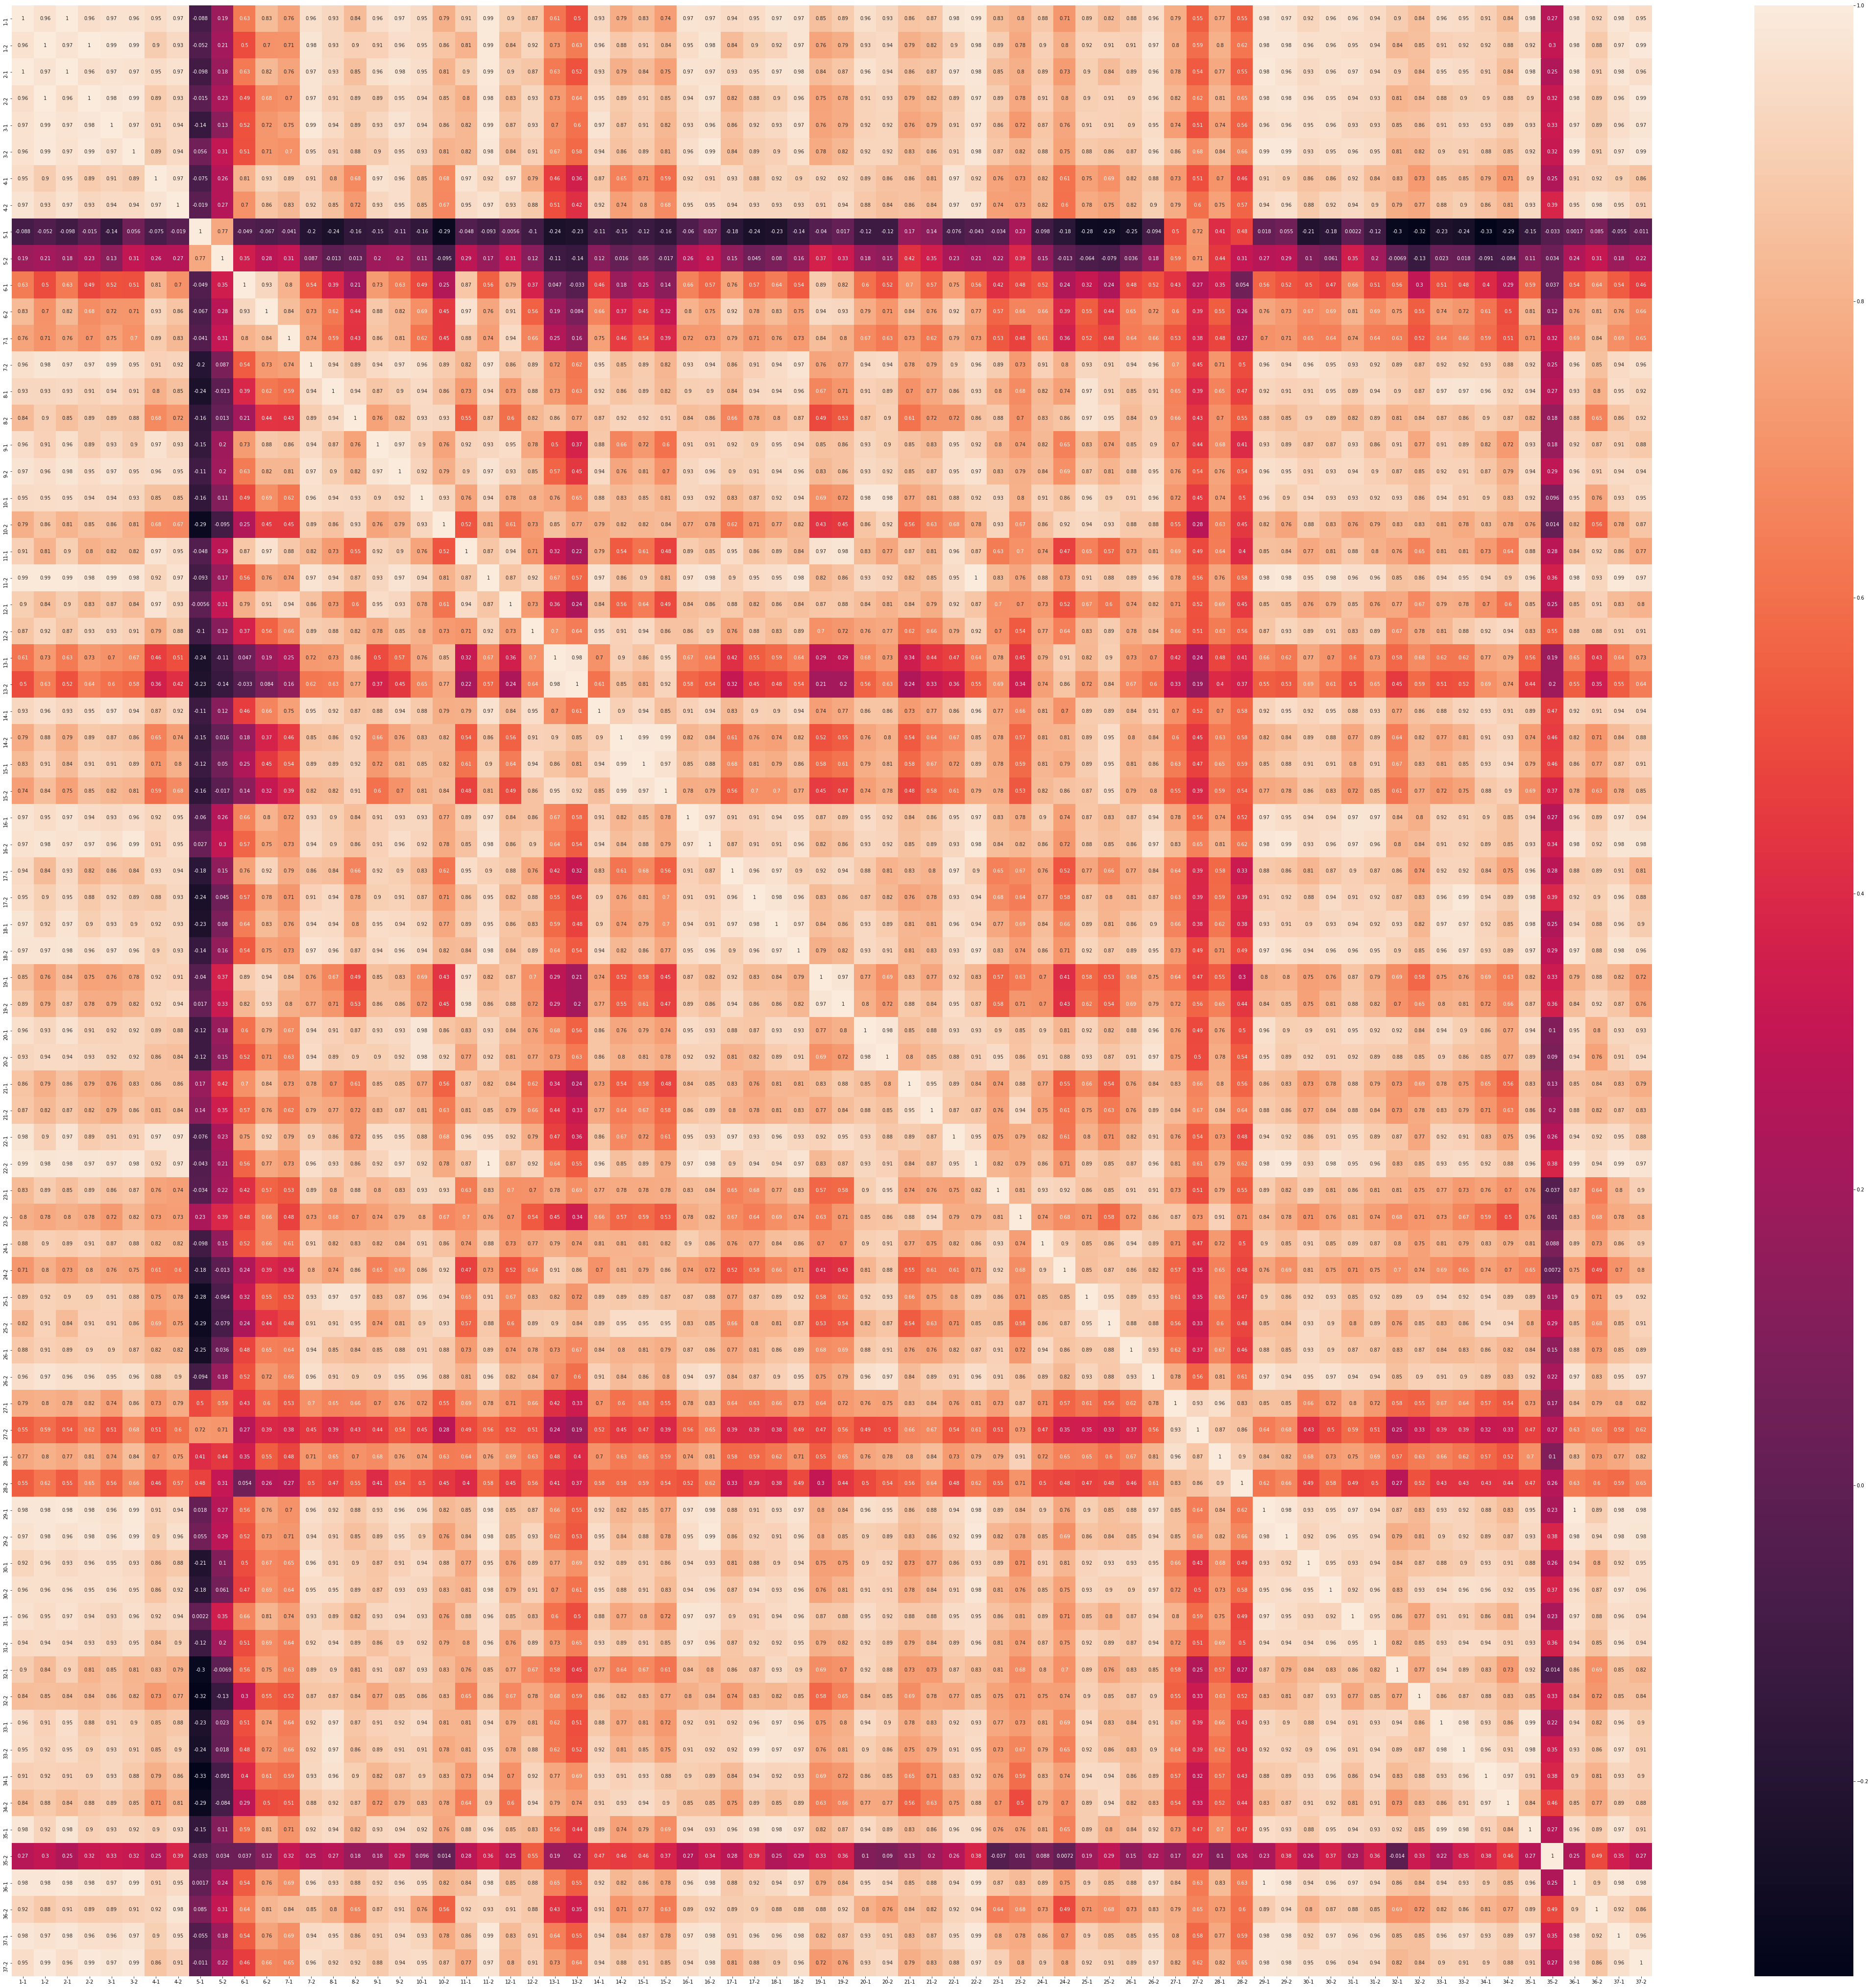

In [45]:
generate_heatmap(newdf[cols],name='heatmapSort.svg')

points         1-1         1-2         2-1         2-2         3-1  \
0       2.0   35.831466   10.854316   38.655380   12.559035   34.601286   
1       2.1   36.503263    9.347854   40.682986    9.168256   28.448175   
2       2.2   40.141300   10.243557   49.453811   13.199541   28.841078   
3       2.3   43.582271   12.081658   56.607198   15.795942   32.541727   
4       2.4   47.626531   14.107032   61.580763   20.780424   43.846400   
..      ...         ...         ...         ...         ...         ...   
375    39.5  202.639178  151.552976  216.272270  195.057890  178.886553   
376    39.6  203.840777  150.895770  214.953077  194.388206  178.480727   
377    39.7  205.042376  149.975576  213.633884  193.715229  178.074901   
378    39.8  204.858826  149.004790  212.572484  192.450022  177.992174   
379    39.9  203.204447  147.914824  211.784822  189.789693  178.252532   

            3-2         4-1         4-2         5-1  ...        33-1  \
0     23.379331   36.028043   24.367646   46.697316  ...   39.380165   
1     21.109158   36.343334   26.395915   50.756641  ...   46.078063   
2     21.760903   41.370656   29.019489   52.296856  ...   55.218919   
3     24.797840   49.473918   34.207097   60.916107  ...   60.881636   
4     24.788418   55.466184   36.498829   63.239173  ...   67.431845   
..          ...         ...         ...         ...  ...         ...   
375  201.238692  129.271951  269.413706  144.250307  ...  194.761582   
376  200.830819  130.212050  271.668820  144.638654  ...  191.428585   
377  199.713534  131.152149  273.892134  145.027001  ...  188.497973   
378  197.722652  131.304465  274.886499  145.484478  ...  187.664261   
379  193.673832  130.620268  272.985824  146.015362  ...  186.830550   

           33-2        34-1        34-2        35-1       35-2        36-1  \
0     27.643166   33.089068   32.696786   31.287359   9.365907   24.899631   
1     26.537808   32.833886   35.786018   38.931895  -2.458811   28.685107   
2     27.845675   36.437981   43.572950   56.849584  -6.513981   31.584341   
3     35.004549   45.623161   45.796943   64.090568  -5.482379   38.154579   
4     44.552451   42.125746   48.353015   80.310634  -4.833052   44.674865   
..          ...         ...         ...         ...        ...         ...   
375  347.833090  253.085053  279.428447  146.671572  11.143336  104.945277   
376  339.052777  248.731190  273.988732  144.243529  11.676621  109.159047   
377  334.883315  244.061851  268.392409  141.909165  10.117428  112.470061   
378  330.713853  237.748501  262.796086  140.062985   8.558235  111.076652   
379  323.122040  231.435150  254.979710  138.216806   8.238276  109.683243   

           36-2        37-1        37-2  
0      0.396093   35.496559   29.801581  
1      3.360554   44.527713   31.890749  
2     12.751300   52.341045   30.716081  
3     10.595388   50.909709   31.883315  
4     17.624751   50.919086   35.278864  
..          ...         ...         ...  
375  199.487356  161.498151  166.885199  
376  199.852052  161.218134  169.833999  
377  195.916133  160.082276  170.173192  
378  191.980213  154.486474  170.512385  
379  194.233554  148.890672  167.821128  

[380 rows x 75 columns]

In [23]:
spectra,names = generate_spectra(newdf)

In [24]:
names

Index(['1-1', '2-1', '3-1', '4-1', '5-1', '6-1', '7-1', '8-1', '9-1', '10-1',
       '11-1', '12-1', '13-1', '14-1', '15-1', '16-1', '17-1', '18-1', '19-1',
       '20-1', '21-1', '22-1', '23-1', '24-1', '25-1', '26-1', '27-1', '28-1',
       '29-1', '30-1', '31-1', '32-1', '33-1', '34-1', '35-1', '36-1', '37-1',
       '1-2', '2-2', '3-2', '4-2', '5-2', '6-2', '7-2', '8-2', '9-2', '10-2',
       '11-2', '12-2', '13-2', '14-2', '15-2', '16-2', '17-2', '18-2', '19-2',
       '20-2', '21-2', '22-2', '23-2', '24-2', '25-2', '26-2', '27-2', '28-2',
       '29-2', '30-2', '31-2', '32-2', '33-2', '34-2', '35-2', '36-2', '37-2'],
      dtype='object')

In [30]:
pairsCorrelation = []
for i in range(0,37):
    pairsCorrelation.append([str(i+1),1-compute_distance(spectra[i],spectra[37+i],'correlation')])

In [31]:
pairsCorrelation

[['1', 0.9649494560908027],
 ['2', 0.9608378860948177],
 ['3', 0.968362904138677],
 ['4', 0.9696438034800624],
 ['5', 0.7746407489677569],
 ['6', 0.932092231839326],
 ['7', 0.7420068864851624],
 ['8', 0.9386330849490209],
 ['9', 0.9745959766012071],
 ['10', 0.9289083331039718],
 ['11', 0.8653763369964479],
 ['12', 0.730793120215871],
 ['13', 0.9798845332550354],
 ['14', 0.903436419920303],
 ['15', 0.9677479336896782],
 ['16', 0.9686264408431392],
 ['17', 0.955225991031914],
 ['18', 0.9697576896803373],
 ['19', 0.9742681896652484],
 ['20', 0.982735744007822],
 ['21', 0.9534526331691967],
 ['22', 0.9506753194394792],
 ['23', 0.8136858219609266],
 ['24', 0.9043141420031661],
 ['25', 0.9481087295057914],
 ['26', 0.926796368562879],
 ['27', 0.93028985750458],
 ['28', 0.9027606886439221],
 ['29', 0.9802614270186604],
 ['30', 0.9510487341310536],
 ['31', 0.9527401285876208],
 ['32', 0.7736156436843481],
 ['33', 0.9834974837619201],
 ['34', 0.972704170580594],
 ['35', 0.2681032720714476],
 ['3

In [33]:
dfPairs = pd.DataFrame(pairsCorrelation,columns=['sample','similarity'])

In [34]:
dfPairs.to_csv('sampleSimilarity.csv',index=None)

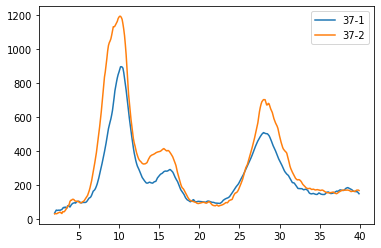

In [38]:
for i in range(0,37):
    plt.clf()
    plt.plot(newdf['points'],newdf[str(i+1)+'-1'],
             newdf['points'],newdf[str(i+1)+'-2'])
    plt.legend([str(i+1)+'-1',str(i+1)+'-2'])
    plt.savefig('samples/'+str(i+1)+'.png')